## Reading Dataset and Visualizing Network Graph

In [1]:
# importing required modules
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# reading and loading the dataset
Dataset = pd.read_csv('Final_Network.csv')

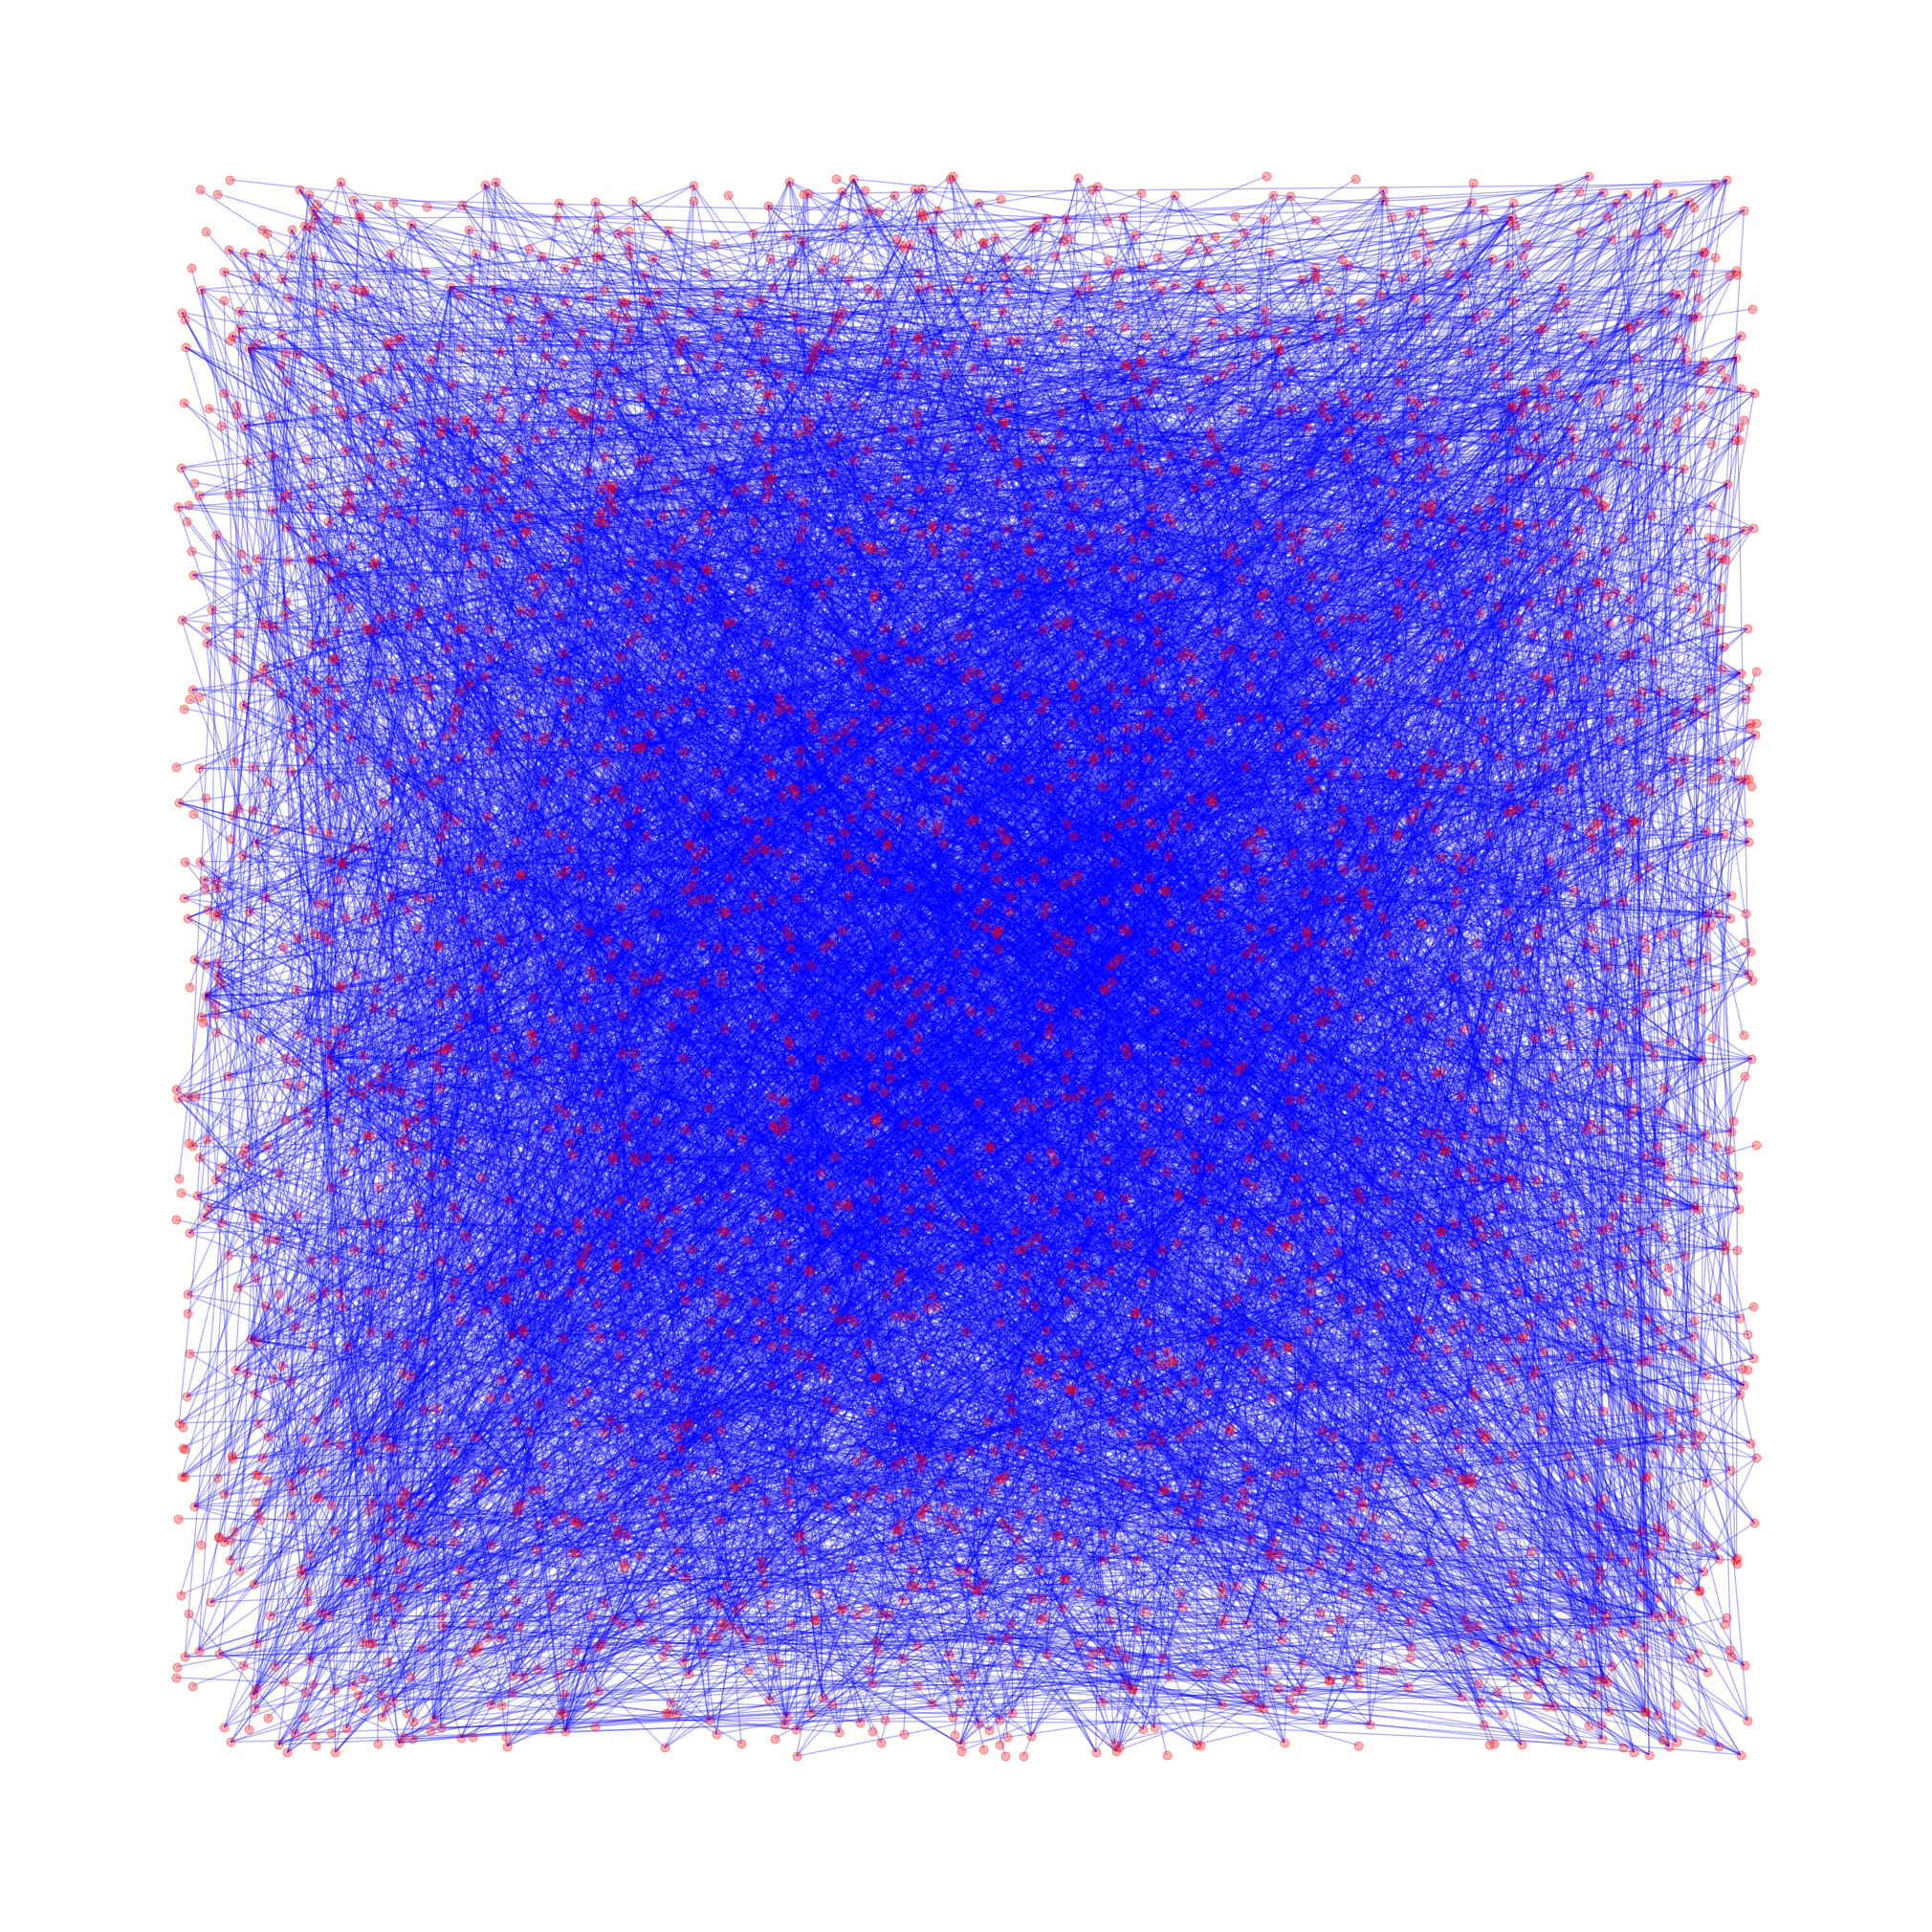

In [3]:
# graph object construction
Graph = nx.from_pandas_edgelist(Dataset, 'Source', 'Target', create_using = nx.Graph())
plt.figure(figsize = (20, 20))
pos = nx.random_layout(Graph, seed = 30)
nx.draw(Graph, with_labels = False,  pos = pos, node_size = 40, alpha = 0.3, edge_color = 'blue', node_color = 'red')
plt.show()

## Finding Missing Edges from the Network

In [4]:
Source = set(Dataset['Source'].unique())
Target = set(Dataset['Target'].unique())
Nodes = list(Source.union(Target))
Number_of_Nodes = len(Nodes)
Adjacency_Matrix = nx.to_numpy_array(Graph, nodelist = Nodes)

In [5]:
Missing_Nodes = []
Number = 0
for i in tqdm(range(Number_of_Nodes)):
    for j in range(Number, Number_of_Nodes):
        if(i != j):
            try:
                if nx.shortest_path_length(Graph, Nodes[i], Nodes[j]) <= 2: 
                    if Adjacency_Matrix[i,j] == 0:
                        Missing_Nodes.append([Nodes[i], Nodes[j]])
            except:
                continue
    Number += 1

100%|██████████| 3364/3364 [09:55<00:00,  5.65it/s] 


## Sampling a Part of Connected Edges for Training

In [6]:
Removed_Edges = []
DF = Dataset.copy()
N = 0
for i in tqdm(Dataset.index.values):
    Current = nx.from_pandas_edgelist(DF.drop(index = i), 'Source', 'Target', create_using = nx.Graph())
    if(nx.number_connected_components(Current) == 1 and len(Current.nodes) == Number_of_Nodes):
        N += 1
        if(N >= 2):
            N = 0
            continue
        Removed_Edges.append(i)
        DF = DF.drop(index = i)

100%|██████████| 10000/10000 [04:40<00:00, 35.59it/s]


## Combining Data of Connected and Missing Edges for Training

In [7]:
Positive_Samples = Dataset.loc[Removed_Edges]
Positive_Samples['Label'] = 1

In [8]:
Positive_Samples.columns

Index(['Source', 'Target', 'Label'], dtype='object')

In [9]:
Positive_Samples

Source  Target  Label
0          1       2      1
2          1       5      1
4          2      11      1
6          2      13      1
8          3      63      1
...      ...     ...    ...
9973    2078      76      1
9977    2079     966      1
9982    2080    2186      1
9988    2081    1849      1
9992    2082     980      1

[4330 rows x 3 columns]

In [10]:
Positive_Samples.to_csv('Positive_Samples.csv')

In [11]:
Negative_Samples = pd.DataFrame(list(Missing_Nodes), columns = ['Source', 'Target'])
Negative_Samples['Label'] = 0

In [12]:
Negative_Samples = Negative_Samples.head(4330)

In [13]:
Negative_Samples

Source  Target  Label
0          1       6      0
1          1       7      0
2          1       8      0
3          1       9      0
4          1      10      0
...      ...     ...    ...
4325      82     305      0
4326      82     317      0
4327      82     354      0
4328      82     358      0
4329      82     386      0

[4330 rows x 3 columns]

In [14]:
Negative_Samples.to_csv('Negative_Samples.csv')

In [15]:
Train_Dataset = pd.concat([Positive_Samples, Negative_Samples], axis = 0)

In [16]:
Train_Dataset

Source  Target  Label
0          1       2      1
2          1       5      1
4          2      11      1
6          2      13      1
8          3      63      1
...      ...     ...    ...
4325      82     305      0
4326      82     317      0
4327      82     354      0
4328      82     358      0
4329      82     386      0

[8660 rows x 3 columns]

In [17]:
Train_Dataset.to_csv('Train_Dataset.csv')

In [18]:
X_Dataset = Train_Dataset[['Source', 'Target']]
Y_Dataset = Train_Dataset['Label']
X_Train, X_Test, Y_Train, Y_Test  = train_test_split(X_Dataset, Y_Dataset, test_size = 0.3, random_state = 10)

## Training Samples using Support Vector Classfier

In [19]:
kernels = ['rbf', 'linear']
c_values = [0.001, 0.01, 0.1, 1]
param_grid = {'kernel':kernels, 'C':c_values}

SVM_Model = GridSearchCV(cv = 10, estimator = svm.SVC(), param_grid = param_grid)

In [20]:
SVM_Model.fit(X_Train, Y_Train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf', 'linear']})

In [21]:
print(classification_report(SVM_Model.best_estimator_.predict(X_Test), Y_Test))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1374
           1       0.94      1.00      0.97      1224

    accuracy                           0.97      2598
   macro avg       0.97      0.97      0.97      2598
weighted avg       0.97      0.97      0.97      2598



In [22]:
print(confusion_matrix(SVM_Model.best_estimator_.predict(X_Test), Y_Test))

[[1292   82]
 [   0 1224]]
